In [1]:
from statistics import mean, stdev
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import roc_curve, auc

In [2]:
cancer = datasets.load_breast_cancer()

data = pd.DataFrame(cancer.data)
data['y'] = cancer.target

x = data.iloc[:,:-1]
y = data.y                   

In [3]:
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
clf = RandomForestClassifier(n_jobs=-1,random_state=0)

In [4]:
skf = StratifiedKFold(n_splits=15,
                      shuffle=True, 
                      random_state=1)

lst_accu_stratified = []

In [5]:
for train_index, test_index in skf.split(x, y):
    
    x_train_fold, x_test_fold = x_scaled[train_index], x_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    clf.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(clf.score(x_test_fold, y_test_fold))

In [6]:
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.9473684210526315, 0.9736842105263158, 0.9473684210526315, 0.9736842105263158, 1.0, 1.0, 0.9736842105263158, 0.9210526315789473, 0.9210526315789473, 1.0, 0.9473684210526315, 0.9736842105263158, 0.9473684210526315, 0.9473684210526315, 0.9459459459459459]

Maximum Accuracy That can be obtained from this model is: 100.0 %

Minimum Accuracy: 92.10526315789474 %

Overall Accuracy: 96.13086770981508 %

Standard Deviation is: 0.02612119598747958


In [7]:
def compute_roc_auc(index):
    y_predict = clf.predict_proba(x.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [8]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)


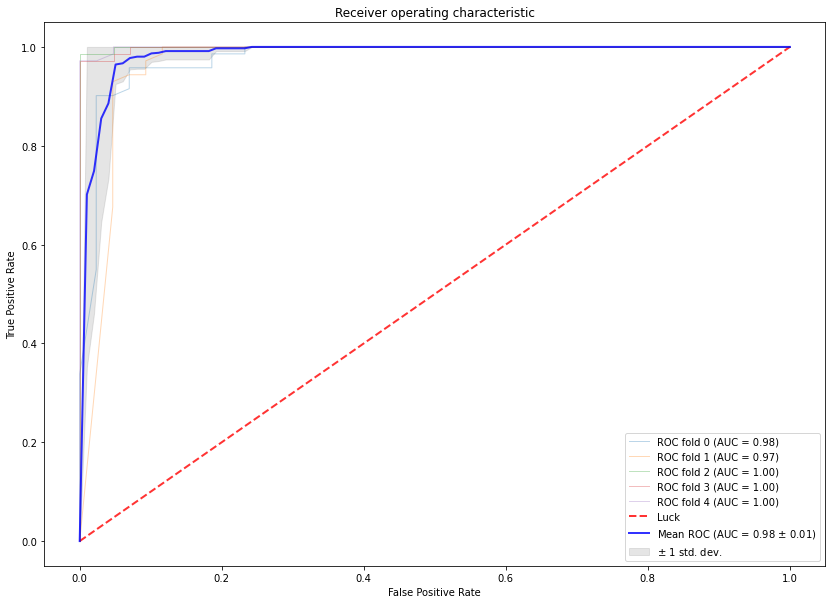

,AUC Train,AUC Test
0,1.0,0.977072
1,1.0,0.965935
2,1.0,0.999339
3,1.0,0.998347
4,1.0,0.998826


In [9]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []
    
for (train, test), i in zip(cv.split(x, y), range(5)):
    clf.fit(x.iloc[train], y.iloc[train])
    
    _, _, auc_score_train = compute_roc_auc(train)
    
    fpr, tpr, auc_score = compute_roc_auc(test)
    
    scores.append((auc_score_train, auc_score))
    
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])